In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift

In [2]:
gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
np.random.seed(29)
Nc = 5  # number of partials
var = 0.25*np.random.rand(Nc)  # variances
leng = 0.5*np.random.rand(Nc)  # lengthscales
f0 = 1000*np.random.rand()
freq = f0*np.asarray(range(1, Nc+ 1)) + np.sqrt(100.)*np.random.randn(Nc) # frequencies
kern1 = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=leng, variances=var, frequencies=freq)
kern2 = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.025, variance=10.)

In [4]:
f0*np.asarray(range(1, Nc+ 1))

array([  241.9864247 ,   483.97284941,   725.95927411,   967.94569882,
        1209.93212352])

In [5]:
print freq
print leng
print var

[  239.94311183   484.99218015   743.30142388   953.79097915  1201.2655431 ]
[ 0.27114844  0.36331789  0.42445255  0.38409999  0.36657186]
[ 0.21594     0.07122649  0.0183141   0.1908093   0.11317976]


In [6]:
N, fs = 1600, 16e3
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)
Kcom = kern1.compute_K_symm(x)
Kact = kern2.compute_K_symm(x)

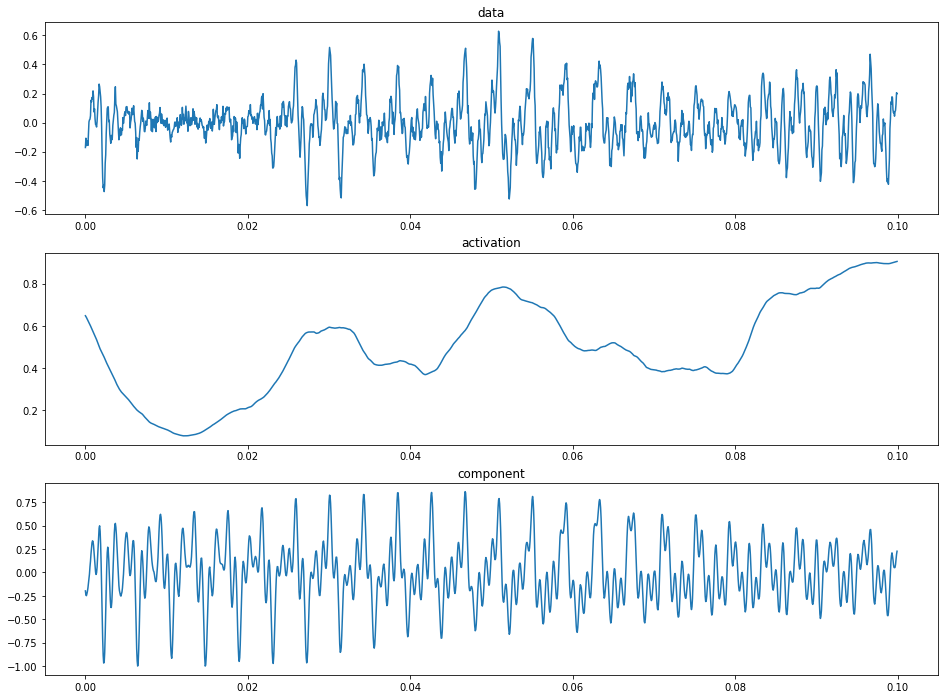

In [7]:
noise_var = 1e-3
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)
com /= np.max(np.abs(com))
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)
act = logistic(g)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y)
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com)

# New component covariance function

In [8]:
params, Y, S, F = gpitch.amtgp.init_com_params(y=y, fs=fs, Nh=Nc, scaled=True)
print params[2]
print params[1]
print params[0]

[[  240.30037554]
 [ 1201.50187757]
 [  492.39185991]
 [  740.92615786]
 [ 1752.19023783]]
[[ 0.65392973]
 [ 0.63893792]
 [ 0.05594435]
 [ 0.62215618]
 [ 0.61527779]]
[[ 0.02399425]
 [ 0.01858046]
 [ 0.20056395]
 [ 0.0060679 ]
 [ 0.00079344]]


In [9]:
kern1

Name,values,prior,constraint
unnamed.frequency_1,[ 239.94311183],None,+ve
unnamed.frequency_2,[ 484.99218015],None,+ve
unnamed.frequency_3,[ 743.30142388],None,+ve
unnamed.frequency_4,[ 953.79097915],None,+ve
unnamed.frequency_5,[ 1201.2655431],None,+ve
unnamed.lengthscale_1,[ 0.27114844],None,+ve
unnamed.lengthscale_2,[ 0.36331789],None,+ve
unnamed.lengthscale_3,[ 0.42445255],None,+ve
unnamed.lengthscale_4,[ 0.38409999],None,+ve
unnamed.lengthscale_5,[ 0.36657186],None,+ve


In [10]:
kern2

Name,values,prior,constraint
unnamed.lengthscales,[ 0.025],None,+ve
unnamed.variance,[ 10.],None,+ve


In [11]:
kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, ideal_f0=f0, Nc=Nc)
kern_act = gpflow.kernels.Matern32(1)

In [12]:
ws, dec = N//1, 80  # samples per window, decimation factor
m = gpitch.modpdet.ModPDet(x=x, y=y, kern_com=kern_com, kern_act=kern_act, ws=ws, dec=dec, whiten=True)
m.model.kern1.fixed = False
m.model.kern2.fixed = False
m.model.likelihood.noise_var.fixed = False

In [13]:
maxiter, restarts = 500, 5
init_hyper, learnt_hyper, mse = m.optimize_restart(maxiter=maxiter, restarts=restarts)

| len: 0.05821566, 0.08415334 | sig: 9.76633233, 9.24015077 | noise_var: 0.05582299, 0.00457735 |
| len: 0.84049754, 0.05067736 | sig: 7.23523669, 6.80602402 | noise_var: 0.02589634, 0.00443157 |
| len: 0.31149206, 0.04039634 | sig: 4.49004279, 3.29838910 | noise_var: 0.09431234, 0.00346431 |
| len: 0.69274648, 0.05509844 | sig: 6.90818543, 6.32617939 | noise_var: 0.05660386, 0.00343520 |
| len: 0.75366163, 0.04331915 | sig: 0.07946257, 3.77769062 | noise_var: 0.09362622, 0.00339420 |


In [14]:
m.model.kern2.lengthscales = learnt_hyper[0].mean().copy()
m.model.kern2.variance = learnt_hyper[1].mean().copy()
m.model.likelihood.noise_var = learnt_hyper[2].mean().copy()

In [15]:
#m.model.kern2

In [16]:
#m.model.kern1

In [17]:
#print m.model.likelihood.noise_var

In [18]:
m.optimize_windowed(disp=1, maxiter=1000)

In [19]:
print freq
print leng
print var

[  239.94311183   484.99218015   743.30142388   953.79097915  1201.2655431 ]
[ 0.27114844  0.36331789  0.42445255  0.38409999  0.36657186]
[ 0.21594     0.07122649  0.0183141   0.1908093   0.11317976]


In [20]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 240.34785716],None,+ve
kern1.frequency_2,[ 485.86525994],None,+ve
kern1.frequency_3,[ 742.82449027],None,+ve
kern1.frequency_4,[ 963.06139025],None,+ve
kern1.frequency_5,[ 1201.85398524],None,+ve
kern1.lengthscale_1,[ 0.49886779],None,"[0.0, 0.5]"
kern1.lengthscale_2,[ 0.49125481],None,"[0.0, 0.5]"
kern1.lengthscale_3,[ 0.49545101],None,"[0.0, 0.5]"
kern1.lengthscale_4,[ 0.49414651],None,"[0.0, 0.5]"
kern1.lengthscale_5,[ 0.4991543],None,"[0.0, 0.5]"


In [21]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.04753909],None,+ve
kern2.variance,[ 5.20569713],None,+ve


In [22]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None
[ 0.00336799]


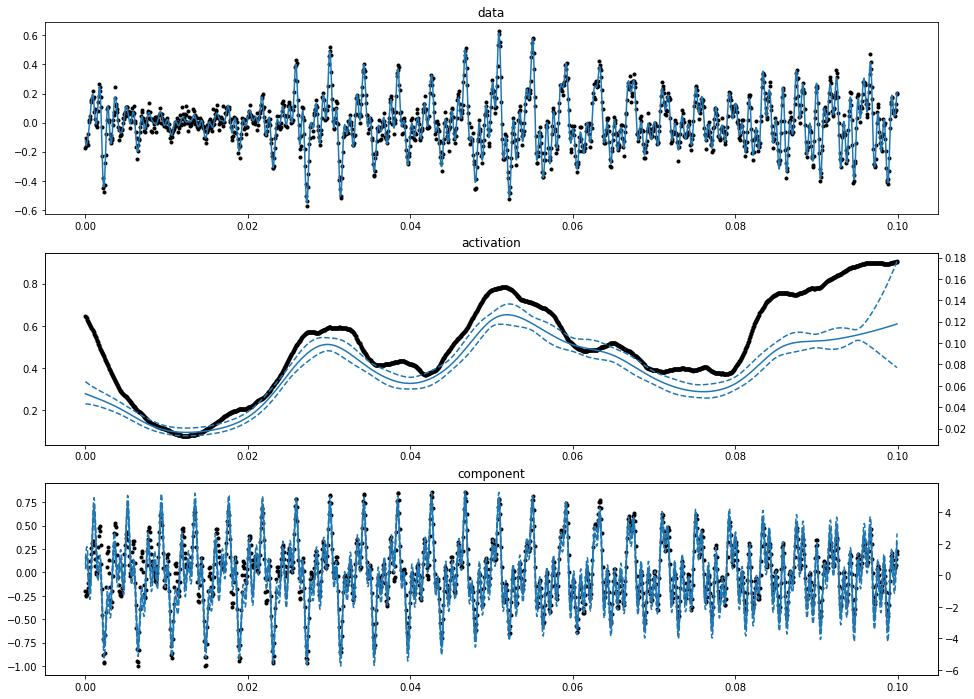

In [23]:
mean_f, var_f = m.model.predict_f(x)
mean_g, var_g = m.model.predict_g(x)
mean_act = logistic(mean_g)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(x, y, '.k'), plt.title('data')
plt.plot(x, act*com)

plt.subplot(3,1,2)
plt.plot(x, act, '.k'), plt.title('activation')
plt.twinx()
plt.plot(x, mean_act)
plt.plot(x, logistic(mean_g + 2.*np.sqrt(var_g)), '--C0')
plt.plot(x, logistic(mean_g - 2.*np.sqrt(var_g)), '--C0')

plt.subplot(3,1,3)
plt.plot(x, com, '.k'), plt.title('component')
plt.twinx()
plt.plot(x, mean_f)
plt.plot(x, mean_f + 2.*np.sqrt(var_f), '--C0')
plt.plot(x, mean_f - 2.*np.sqrt(var_f), '--C0')

In [24]:
# plt.figure(figsize=(16, 12))
# plt.subplot(3,1,1)
# plt.plot(x, y, '.k'), plt.title('data')
# plt.plot(x, logistic(m.qm2)*m.qm1)

# plt.subplot(3,1,2)
# plt.plot(x, act, '.k'), plt.title('activation')
# plt.plot(x, logistic(m.qm2))

# plt.subplot(3,1,3)
# plt.plot(x, com, '.k'), plt.title('component')
# plt.plot(x, m.qm1)